# Deep learning の練習 (GPU利用版)

* scikit-learn の iris データを例に、ai-chan で機械学習をする
* CPU に比べて 10 倍ぐらい時間がかかる (10000 エポックの学習で CPU 3秒 vs GPU 30秒)
* 結果はちゃんとでている
* きっと問題がもっと大きくなれば、どっかで GPU のほうが逆転するんだろう
  * Iris は、3パラメータ × 150 データ 問題が小さすぎる
  * 画像認識のように 1データが 100px x 100px = 10000パラメータ とかになってくると GPU が効いてくる ... と期待

In [1]:
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt
from sklearn import datasets

import sys,os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from ai_chan import gpu, layer, util

# データの読み込み
* 1列が1つのデータセットになるように、読み込んだデータを転置する
* 機械学習の基本のキ → 教師データを学習用と、検証用に分ける

In [2]:
# データセットのロード
# iris.data = [(がく片の長さ , がく片の幅 , 花びらの長さ , 花びらの幅)]
iris = datasets.load_iris()
# データをシャッフルする (ミソ!)
np.random.shuffle(iris.data)

x_vals = np.array([x[0:3] for x in iris.data])
d_vals = np.array([x[3] for x in iris.data])

data_size = len(x_vals)
train_size = int(data_size * 0.8)
test_size = data_size - train_size

x_train = x_vals[0:train_size].T
d_train = d_vals[0:train_size].T

x_eval = x_vals[train_size:data_size].T
d_eval = d_vals[train_size:data_size].T

print ("total:{} = train:{} + test:{}".format(data_size, len(x_train[0]), len(x_eval[0])))

total:150 = train:120 + test:30


# 機械学習
* 学習率は、0.001
* 10000 回学習を行う

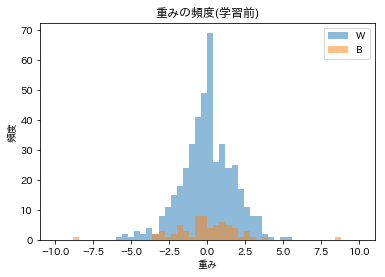

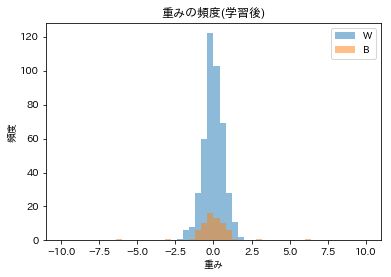

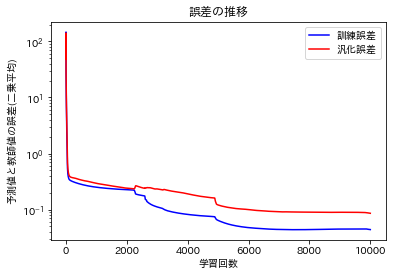

In [3]:
net = gpu.GPUNet()

# 入力データを(初期状態で)標準化スコアに変換する前処理層
# 3→6
net.add_pre_layer(layer.Normalize(), activate_function=gpu.ReLu(), x=x_vals.T)

# 中間層は 6→60
net.add_layer(60, activate_function=gpu.ReLu())

# 出力層は 60→1
net.add_layer(1, layer_factory=layer.Random(), activate_function=gpu.IdentityMapping())

# 学習係数は 0.001固定 (呼び出し回数で減衰させるとうまく収束しない)
net.set_learning_rate(gpu.Static())

# 正則化（重み減衰)
# net.set_weight_decay(weight.L1Decay())
net.set_weight_decay(gpu.L2Decay())
# net.set_weight_decay(weight.LmaxDecay())
# net.set_weight_decay(gpu.NoDecay())

plt.figure()
plt.title("重みの頻度(学習前)")
plt.xlabel("重み")
plt.ylabel("頻度")
util.draw_hist(net.w, "W")
util.draw_hist(net.b, "B")
plt.legend()
plt.show()

# 訓練誤差
tx = []
te = []
# 汎化誤差
gx = []
ge = []

# 精度を変えても収束の影響なし
cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)
gpu_x_eval = cp.asarray(x_eval, dtype=gpu.FLOAT_PRECISION)
gpu_d_eval = cp.asarray(d_eval, dtype=gpu.FLOAT_PRECISION)
gpu_x_train = cp.asarray(x_train, dtype=gpu.FLOAT_PRECISION)
gpu_d_train = cp.asarray(d_train, dtype=gpu.FLOAT_PRECISION)

net.to_gpu()

for cnt in range(0, 10000):
    # 順伝搬 (評価用)
    gpu_gy = net.forward(gpu_x_eval)

    # 誤差評価 (評価用)
    gx.append(cnt)
    error = util.least_square_average(d_eval, gpu_gy.get())
    # print("{}:{}".format(cnt, gpu_gy.get()))
    ge.append(error)

    # 順伝搬 (訓練用)
    gpu_y = net.forward(gpu_x_train)

    # 誤差評価 (訓練用)
    tx.append(cnt)
    error = util.least_square_average(d_train, gpu_y.get())
    te.append(error)

    # 逆伝搬
    gpu_dEdW, gpu_dEdB = net.backward(gpu_d_train, gpu_y)
    # パラメータ修正
    net.adjust_network(gpu_dEdW, gpu_dEdB)
    
net.to_cpu()

plt.figure()
plt.title("重みの頻度(学習後)")
plt.xlabel("重み")
plt.ylabel("頻度")
util.draw_hist(net.w, "W")
util.draw_hist(net.b, "B")
plt.legend()
plt.show()

plt.figure()
plt.title("誤差の推移")
plt.xlabel("学習回数")
plt.ylabel("予測値と教師値の誤差(二乗平均)")

plt.yscale("log")
plt.plot(tx, te, color='blue', label='訓練誤差')
plt.plot(gx, ge, color='red', label='汎化誤差')
plt.legend()
plt.show()

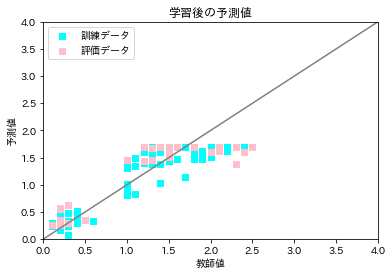

In [4]:
y = gpu_y.get()
gy = gpu_gy.get()

plt.figure()
plt.title("学習後の予測値")
plt.xlabel("教師値")
plt.ylabel("予測値")
plt.xlim(0.0, max(4.0, np.max(d_train), np.max(d_eval)))
plt.ylim(0.0, max(4.0, np.max(y), np.max(gy)))
plt.scatter(d_train.T, y.T, color="cyan", marker="s", label="訓練データ")
plt.scatter(d_eval.T, gy.T, color="pink", marker="s", label="評価データ")

x = np.arange(-10,10,0.1)
plt.plot(x, x, color="gray")
plt.legend()
plt.show()